## 掛接 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50

## 載入資料

In [10]:
# 確認壓縮檔路徑
# filepath='../../../../images/stanfor_dogs'
# os.listdir(filepath)

['.DS_Store', 'test', 'train']

In [11]:
# # 解壓縮檔案
# !unzip '/content/drive/MyDrive/20222電機系電腦視覺/HW3/stanford_dogs.zip' -d '/content/drive/MyDrive/20222電機系電腦視覺/HW3/'

In [7]:
dirpath='../../../../images/stanfor_dogs/'
os.listdir(dirpath) 

['.DS_Store', 'test', 'train']

In [8]:
imgSize=(224,224)
imgShape=(224,224,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      rotation_range = 40,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=batchSize,
    target_size= imgSize,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [9]:
base_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape=imgShape,
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dropout(0.25)(x)
output_layer = layers.Dense(units = 120, activation = 'softmax')(x)

# freeze the weight
base_model.trainable = False

model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-15 15:37:25.507117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-15 15:37:25.507264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [10]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


## train model

In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
epoch=50
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_reduceLROnPlateau_callback=tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3,verbose = 1, factor=0.5, min_lr = 0.00001)
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
  callbacks=[model_checkpoint_callback, model_reduceLROnPlateau_callback]
)

Epoch 1/50


2022-05-14 18:15:54.498090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - ETA: 0s - loss: 6.0095 - accuracy: 0.0108

2022-05-14 18:17:52.565386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - 163s 614ms/step - loss: 6.0095 - accuracy: 0.0108 - val_loss: 5.5993 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 2/50
262/262 [==============================] - 180s 686ms/step - loss: 5.8198 - accuracy: 0.0114 - val_loss: 5.5833 - val_accuracy: 0.0156 - lr: 0.0100
Epoch 3/50
262/262 [==============================] - 167s 639ms/step - loss: 5.7166 - accuracy: 0.0159 - val_loss: 5.2284 - val_accuracy: 0.0181 - lr: 0.0100
Epoch 4/50
262/262 [==============================] - 175s 668ms/step - loss: 5.7207 - accuracy: 0.0195 - val_loss: 5.5647 - val_accuracy: 0.0229 - lr: 0.0100
Epoch 5/50
262/262 [==============================] - 175s 668ms/step - loss: 5.6926 - accuracy: 0.0197 - val_loss: 5.3555 - val_accuracy: 0.0198 - lr: 0.0100
Epoch 6/50
262/262 [==============================] - ETA: 0s - loss: 5.6812 - accuracy: 0.0206

KeyboardInterrupt: 

In [26]:
# continue train
# # 載入最近的檢查點的權重
model.load_weights("./checkpoint/")
# # 訓練 5 次
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
  callbacks=[model_checkpoint_callback, model_reduceLROnPlateau_callback]
)

KeyboardInterrupt: 

## show the loss & accuracy curve

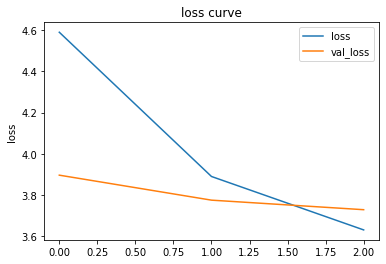

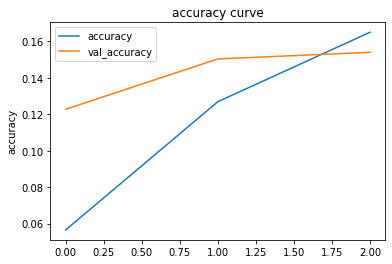

In [23]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [24]:
prediction = model.predict(testBatch)
prediction

2022-05-13 20:58:08.347841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[3.77289369e-04, 2.71889434e-07, 5.95389838e-06, ...,
        5.68596320e-03, 1.77584076e-03, 3.18343227e-05],
       [1.48700429e-02, 1.40632756e-05, 1.51477925e-05, ...,
        6.00507855e-02, 6.57338882e-03, 1.24320248e-03],
       [2.40399658e-07, 4.18088177e-08, 5.16766789e-08, ...,
        2.38638222e-05, 7.93135132e-06, 2.49802833e-04],
       ...,
       [2.46528711e-04, 5.48714415e-05, 5.53071641e-06, ...,
        4.84842621e-03, 3.14728497e-03, 1.35808287e-03],
       [5.24034185e-05, 2.04630865e-04, 6.56473567e-04, ...,
        3.60259530e-03, 2.65750481e-04, 2.92161538e-04],
       [2.29146826e-04, 5.45965595e-05, 5.30243036e-04, ...,
        3.96261428e-04, 1.14246632e-05, 3.95926827e-06]], dtype=float32)

## 輸出結果

In [ ]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/20222電機系電腦視覺/HW3/prediction.csv',index=False)

In [ ]:
import tensorflow as tf

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train1, y_train1), (x_test1, y_test1) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train1[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  